# Ray start/stop

In [ ]:
ray.init(ignore_reinit_error=True)

In [ ]:
import ray
ray.shutdown()

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import datetime as dt
import numpy as np
import pandas as pd
pd.set_option('float_format', '{:f}'.format)
pd.set_option('display.max_rows', 70)
pd.set_option('display.max_columns', 99)
import pandas_bokeh
pandas_bokeh.output_file("data/bokeh_output.html")

import polygon_df as pdf
import polygon_ds as pds
import polygon_s3 as ps3
import bar_samples as bs
import bar_labels as bl
import bar_workflow as bw
import utils_filters as ft
from utils_pickle import pickle_dump, pickle_load

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import style
style.use('fivethirtyeight')
mpl.rcParams['figure.figsize'] = [20, 7]

# df.style.background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)  # 'Blues', 'coolwarm', 'RdBu_r' & 'BrBG'
# pd.set_option('precision', 2)
# .plot_bokeh(sizing_mode="scale_height")
# set sampling params

# Sample tick dates

In [3]:
# set sampling params
symbol = 'VTI'
start_date = '2020-11-18'
end_date = '2020-11-20'
date = '2020-11-19'

thresh = {
    # mad filter
    'mad_value_winlen': 11,
    'mad_k': 22,    
    'mad_deviation_winlen': 333,     
    # jma filter
    'jma_winlen': 7,
    'jma_power': 2,
    # bar thresholds
    'renko_return': 'jma_return',
    'renko_size': 0.11,
    'renko_reveral_multiple': 2,
    'renko_range_frac': 22,
    'max_duration_td': dt.timedelta(minutes=33),
    'min_duration_td': dt.timedelta(seconds=11),
    'min_tick_count': 33,
    # label params
    'label_reward_ratios': list(np.arange(2, 11, 0.5)),
}

In [64]:
# bar flow
bar_dates = bw.bar_workflow(symbol, date='2020-11-19', thresh=thresh, add_label=True)

tdf = bar_dates['ticks_df']
bdf = bar_dates['bars_df']

VTI 2020-11-19 trying to get data from local file...


/Users/bobcolner/QuantClarity/pandas-polygon/bar_samples.py:208: UserWarning: Discarding nonzero nanoseconds in conversion
  }


In [83]:
tdf=bar_dates[2]['ticks_df']
bdf=bar_dates[2]['bars_df']

In [84]:
bdf

,bar_trigger,open_at,close_at,duration_td,price_open,price_close,price_low,price_high,price_range,price_return,price_wq10,price_wq50,price_wq90,price_wq_range,price_wmean,price_wstd,jma_open,jma_close,jma_low,jma_high,jma_range,jma_return,jma_wq10,jma_wq50,jma_wq90,jma_wq_range,jma_wmean,jma_wstd,tick_count,volume,dollars,tick_imbalance,volume_imbalance,dollar_imbalance,label_side,label_outcome,label_rrr,label_outcome_at,label_start_at,label_end_at
0,renko_down,2020-11-20 09:30:00.150367232-05:00,2020-11-20 09:30:14.719971072-05:00,0 days 00:00:14.569603840,184.073303,184.020004,184.020004,184.190002,0.169998,-0.053299,184.029999,184.110001,184.190002,0.160004,184.103552,0.059385,184.245922,184.032463,184.032463,184.245922,0.213459,-0.213459,184.051562,184.125477,184.173354,0.121792,184.112753,0.047073,52,1154,212455.499344,-10,-290,-53337.412338,neutral,neutral,0.000000,2020-11-20 09:35:14.263921920-05:00,2020-11-20 09:30:14.719971072-05:00,2020-11-20 10:03:14.719971072-05:00
1,renko_down,2020-11-20 09:30:14.719980800-05:00,2020-11-20 09:32:04.273734912-05:00,0 days 00:01:49.553754112,184.020004,183.889801,183.889801,184.110001,0.220200,-0.130203,183.910004,183.980301,184.043793,0.133789,183.979422,0.050752,184.026506,183.909888,183.902827,184.080135,0.177308,-0.116618,183.924987,183.992144,184.055198,0.130211,183.982119,0.048659,210,7567,1392172.286652,-58,-2481,-456432.475983,neutral,neutral,0.000000,2020-11-20 09:35:14.281933312-05:00,2020-11-20 09:32:04.273734912-05:00,2020-11-20 10:05:04.273734912-05:00
2,renko_down,2020-11-20 09:32:04.273830656-05:00,2020-11-20 09:35:18.604300288-05:00,0 days 00:03:14.330469632,183.860001,183.770004,183.763199,184.080002,0.316803,-0.089996,183.860001,183.954895,184.044998,0.184998,183.944270,0.069876,183.891276,183.782922,183.782922,184.051075,0.268154,-0.108355,183.861946,183.945282,184.046949,0.185002,183.947061,0.068732,206,13558,2493916.417511,-20,-2566,-471953.484650,long,profit,3.000000,2020-11-20 09:43:52.475790080-05:00,2020-11-20 09:35:18.604300288-05:00,2020-11-20 10:08:18.604300288-05:00
3,renko_up,2020-11-20 09:35:20.209233408-05:00,2020-11-20 09:41:56.580485632-05:00,0 days 00:06:36.371252224,183.779999,183.984406,183.750000,184.000000,0.250000,0.204407,183.850006,183.899994,183.940201,0.090195,183.896123,0.040883,183.779311,183.987926,183.763685,183.987926,0.224240,0.208615,183.849502,183.894458,183.952711,0.103208,183.897977,0.041218,450,35043,6444271.837326,-4,2743,504454.172897,neutral,neutral,0.000000,2020-11-20 09:51:30.484916480-05:00,2020-11-20 09:41:56.580485632-05:00,2020-11-20 10:14:56.580485632-05:00
4,renko_up,2020-11-20 09:41:56.693748992-05:00,2020-11-20 09:43:27.275587328-05:00,0 days 00:01:30.581838336,184.020004,184.119995,183.970001,184.119995,0.149994,0.099991,183.979996,184.000000,184.080002,0.100006,184.010995,0.036392,183.997710,184.105937,183.980446,184.105937,0.125491,0.108227,183.982257,184.006504,184.062774,0.080517,184.011391,0.030860,114,7574,1393699.276016,-14,-2796,-514430.163284,short,profit,-5.500000,2020-11-20 10:16:09.643100160-05:00,2020-11-20 09:43:27.275587328-05:00,2020-11-20 10:16:27.275587328-05:00
5,renko_down,2020-11-20 09:43:27.421832192-05:00,2020-11-20 09:51:30.063341568-05:00,0 days 00:08:02.641509376,184.110001,183.899994,183.899994,184.179993,0.279999,-0.210007,184.000000,184.050003,184.119995,0.119995,184.051552,0.049575,184.108932,183.900160,183.900160,184.164140,0.263979,-0.208772,184.000000,184.058965,184.119392,0.119391,184.056498,0.048724,623,49916,9187117.254013,-53,-19954,-3671900.623795,short,profit,-3.500000,2020-11-20 10:16:09.531895808-05:00,2020-11-20 09:51:30.063341568-05:00,2020-11-20 10:24:30.063341568-05:00
6,renko_down,2020-11-20 09:51:30.063834624-05:00,2020-11-20 09:54:15.021264640-05:00,0 days 00:02:44.957430016,183.899994,183.789993,183.789993,183.949493,0.159500,-0.110001,183.839996,183.910095,183.929993,0.089996,183.893710,0.038348,183.900062,183.794012,183.794012,183.940916,0.146904,-0.106050,183.8395

In [82]:
tdf[tdf.status.str.startswith('clean_open')]

,price,volume,status,date_time,jma,side
195,184.073303,8,clean_open_market,2020-11-20 09:30:00.150367232-05:00,184.245922,-1.000000
196,184.073303,11,clean_open_market,2020-11-20 09:30:00.150552832-05:00,184.172400,-1.000000
197,184.179993,1,clean_open_market,2020-11-20 09:30:00.169242368-05:00,184.155977,1.000000
198,184.085007,3,clean_open_market,2020-11-20 09:30:00.180859904-05:00,184.132500,-1.000000
199,184.039993,20,clean_open_market,2020-11-20 09:30:00.302529792-05:00,184.098442,-1.000000
...,...,...,...,...,...,...
25800,183.190002,100,clean_open_market,2020-11-20 15:59:59.990686208-05:00,183.207713,-1.000000
25801,183.210007,1400,clean_open_market,2020-11-20 15:59:59.990691328-05:00,183.205840,1.000000
25802,183.210007,383,clean_open_market,2020-11-20 15:59:59.990691328-05:00,183.206871,1.000000
25803,183.210007,300,clean_open_market,2020-11-20 15:59:59.990695680-05:00,183.208181,1.000000


<AxesSubplot:xlabel='date_time'>

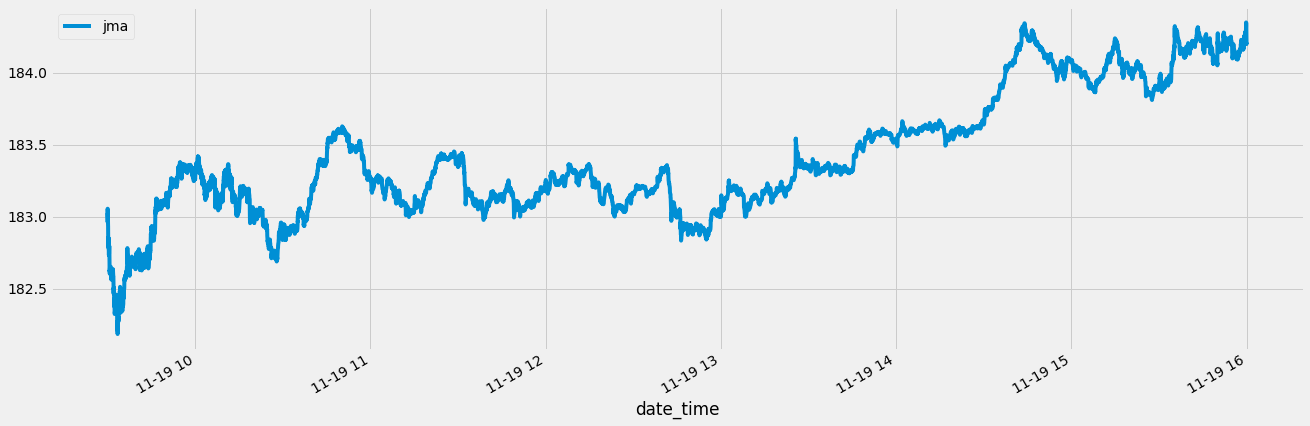

In [66]:
tdf[tdf.status.str.startswith('clean_open_mar')].plot(x='date_time', y='jma')

In [67]:
# bar flow
bar_dates = bw.bar_dates_workflow(symbol, start_date, end_date, thresh, ray_on=True)

# bdf = pd.DataFrame(bar_dates[3]['bars'])
# tdf = pd.DataFrame(bar_dates[3]['ticks_df'])

2021-02-02 22:09:10,747	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:1111


(pid=14833) VTI 2020-11-18 trying to get data from local file...
(pid=14832) VTI 2020-11-19 trying to get data from local file...
(pid=14835) VTI 2020-11-20 trying to get data from local file...


(pid=14832) /Users/bobcolner/QuantClarity/pandas-polygon/bar_samples.py:208: UserWarning: Discarding nonzero nanoseconds in conversion
(pid=14832)   tick = filter_tick(tick, mad_filter, jma_filter, tick_rule)
(pid=14833) /Users/bobcolner/QuantClarity/pandas-polygon/bar_samples.py:208: UserWarning: Discarding nonzero nanoseconds in conversion
(pid=14833)   tick = filter_tick(tick, mad_filter, jma_filter, tick_rule)
(pid=14835) /Users/bobcolner/QuantClarity/pandas-polygon/bar_samples.py:208: UserWarning: Discarding nonzero nanoseconds in conversion
(pid=14835)   tick = filter_tick(tick, mad_filter, jma_filter, tick_rule)


In [ ]:
# fill daily gaps
stacked_df = bw.fill_gaps_dates(bar_dates, fill_col='jma_wmean')

# stacked stats
stats_df = bw.stacked_df_stats(stacked_df)

In [ ]:
stacked_df.jma_wmean.plot()

In [ ]:
ticks_df = ps3.fetch_date_df(symbol, date='2020-11-19', tick_type='trades')

bars, ticks = bs.build_bars(ticks_df, thresh)

tdf = pd.DataFrame(ticks)
bdf = pd.DataFrame(bars)

In [ ]:
tdf[tdf.status=='clean_open_market'].jma.plot()

In [ ]:
tdf[tdf.status=='clean_open_market'].plot(x='date_time', y='jma')

In [ ]:
results = []

for date in bar_dates:
    out = (date['ft_ticks_df'].status.value_counts() / date['ft_ticks_df'].shape[0]).to_dict()
    out.update({'date': date['date']})
    results.append(out)

pd.DataFrame(results)

In [ ]:

# rw, outlier_ind = ft.random_walk_with_outliers(0, 1000, 0.01)
# plt.plot(np.arange(len(rw)), rw)
# plt.scatter(outlier_ind, rw[outlier_ind], c='r', label='outlier')
# plt.title('Random Walk with outliers')
# plt.xlabel('Time steps')
# plt.ylabel('Values')
# plt.legend();

from bokeh.plotting import figure, output_file, show, output_notebook
# output_notebook()

TOOLS = "pan,wheel_zoom,box_zoom,reset,save,box_select"

p1 = figure(title="Legend Example", tools=TOOLS)
p1.line(df.index, df.price)
p1.circle(df[df.mad_outlier==True].index, df[df.mad_outlier==True].price, legend_label="outlier", color="orange")

# output_file("legend.html", title="legend.py example")
show(p1, sizing_mode="scale_height")  # open a browser
